In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K

/home/river/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from timeit import default_timer as timer

import numpy as np
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.utils import to_categorical
from keras_helper import NNWeightHelper
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from snes import SNES
from numpy import argmax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

In [3]:
amazon_path = "/home/river/assi2_ce888/Offical31_datasets/amazon/images"
dslr_path = "/home/river/assi2_ce888/Offical31_datasets/dslr/images"
webcam_path = "/home/river/assi2_ce888/Offical31_datasets/webcam/images"

In [4]:
img_width, img_height = 28, 28
train_data_dir = amazon_path

validation_data_dir = webcam_path

In [5]:

epochs = 30
batch_size = 150
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape,activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3),activation = "relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(31, activation="relu"))

In [7]:
model.compile(loss = "mean_squared_error",
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    #save_to_dir= "/home/river/assi2_ce888/Offical31_datasets/save_pic1",
    target_size=(img_width, img_height),
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    #color_mode ="grayscale",
    batch_size=batch_size,
    class_mode='categorical')

Found 2817 images belonging to 31 classes.
Found 530 images belonging to 21 classes.


In [9]:
train_imgs, train1_labels= next(train_generator)
test_imgs, test1_labels =next(validation_generator) 

In [10]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples= len(validation_generator.filenames)

In [11]:
#shapes_labels=train_generator.class_indices
#shapes_test= validation_generator.class_indices

In [12]:
train_labels = np.zeros((train1_labels.shape[0],), dtype = float)
for i in range(train1_labels.shape[0]):
    train_labels[i] = argmax(train1_labels[i])

In [13]:
test_labels = np.zeros((test1_labels.shape[0],), dtype = float)
for i in range(test1_labels.shape[0]):
    test_labels[i] = argmax(test1_labels[i])

In [14]:
#model.fit_generator(
    #train_generator,
    #steps_per_epoch=nb_train_samples // batch_size,
    #epochs=epochs,
    #validation_data=validation_generator,
    #validation_steps=nb_validation_samples // batch_size)


In [15]:
#score ,acc= model.evaluate_generator(validation_generator, nb_validation_samples // batch_size)


In [16]:
#SAMPLE_SIZE = 1024
#SAMPLE_SIZE = int(math.ceil(nb_train_samples / batch_size))
SAMPLE_SIZE = 8
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 10
# how many times we will loop over ask()/tell()
GENERATIONS = 50

def train_classifier(model, X,y):
    #History= model.predict_generator(X, steps= 177)
    #X_features = History.history
    X_features = model.predict(X)
    #clf = ExtraTreesClassifier(n_estimators=100, n_jobs=4)
    #clf = DecisionTreeClassifier()
    clf = RandomForestClassifier(n_estimators=100, n_jobs=4)

    clf.fit(X_features,y)
    y_pred = clf.predict(X_features)
    return clf, y_pred


def predict_classifier(model, clf, X):
    #X_features = model.predict_generator(X,steps = 177)
    X_features = model.predict(X)
    return clf.predict(X_features)

In [17]:
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

In [18]:
print("Total number of weights to evolve is:", weights.shape)

all_examples_indices = list(range(train_imgs.shape[0]))
clf, _ = train_classifier(model, train_imgs,train_labels)
#clf, _ = train_classifier(model, train_imgs,train_labels)
print("train_imgs shape is :", train_imgs.shape)
print("train-labels shape is :",train_labels.shape)
y_pred = predict_classifier(model, clf, test_imgs)

#y_pred = predict_classifier(model, clf, test_imgs)

print(test_labels.shape, y_pred.shape)
test_accuracy = accuracy_score(test_labels, y_pred)

print('Non-trained NN Test accuracy:', test_accuracy)

Total number of weights to evolve is: (34815,)
train_imgs shape is : (150, 28, 28, 3)
train-labels shape is : (150,)
(150,) (150,)
Non-trained NN Test accuracy: 0.11333333333333333


In [19]:
snes  = SNES(weights, 1 , POPULATION_SIZE)

Step 1.0 : 0.3333333333333333 best: 0.3333333333333333 10
It took 4.1626681109992205 seconds to complete generation 1
Step 2.0 : 0.1111111111111111 best: 0.3333333333333333 10
It took 4.231747063999137 seconds to complete generation 2
Step 3.0 : 0.1111111111111111 best: 0.3333333333333333 10
It took 4.144700863000253 seconds to complete generation 3
Step 4.0 : 0.1111111111111111 best: 0.3333333333333333 10
It took 4.153686272000414 seconds to complete generation 4
Step 5.0 : 0.1111111111111111 best: 0.3333333333333333 10
It took 4.147447782999734 seconds to complete generation 5
Step 6.0 : 0.2222222222222222 best: 0.3333333333333333 10
It took 4.133296437999888 seconds to complete generation 6
Step 7.0 : 0.0 best: 0.3333333333333333 10
It took 4.16521648899834 seconds to complete generation 7
Step 8.0 : 0.0 best: 0.3333333333333333 10
It took 4.163810324000224 seconds to complete generation 8
Step 9.0 : 0.0 best: 0.3333333333333333 10
It took 4.137488413000028 seconds to complete gener

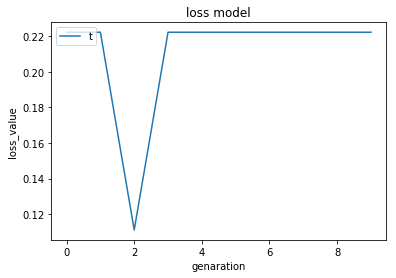

In [20]:
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()
    
    told = []
    subsample_indices  = np.random.choice(all_examples_indices, size= SAMPLE_SIZE,replace = False )
    subsample_indices_valid = np.random.choice(all_examples_indices,size=SAMPLE_SIZE+1, replace = False)
    for asked_j in asked:
        nnw.set_weights(asked_j)
        clf, _ = train_classifier(model, train_imgs[subsample_indices], train_labels[subsample_indices])
        
        y_pred = predict_classifier(model, clf, train_imgs[subsample_indices_valid])
        score = accuracy_score(train_labels[subsample_indices_valid], y_pred)
        
        
        # clf, _ = train_classifier(model, x_train, y_train)
        # y_pred = predict_classifier(model, clf, x_test)
        # score = accuracy_score(y_test, y_pred)
        # append to array of values that are to be returned
        told.append(score)
        
    snes.tell(asked, told)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)

nnw.set_weights(snes.center)

clf, _ = train_classifier(model, train_imgs, train_labels)
y_pred = predict_classifier(model, clf, test_imgs)
#print(told)

print(test_labels.shape, y_pred.shape)
test_accuracy = accuracy_score(test_labels, y_pred)
print('Test accuracy:', test_accuracy)
    
plt.plot(told)
plt.title("loss model")
plt.xlabel("genaration")
plt.ylabel("loss_value")
plt.legend("test",loc = "upper left")
#plt.savefig("amazon_dslr.png")
plt.show()
